### Kaggle Compitition Notebook
- Author : Junaid Amin
- Linkdin : https://www.linkedin.com/in/junaid-amin85/
- Github : https://github.com/juneedpk

### Survival Rate predicted by Neural Network in Tensorflow

In [68]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf


In [69]:
# load the data

df_train = pd.read_csv('train.csv',index_col='PassengerId')
df_test = pd.read_csv('test.csv',index_col='PassengerId')
gender_submission = pd.read_csv('gender_submission.csv')

In [70]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [71]:
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### Lets explore the data in train.csv

In [72]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


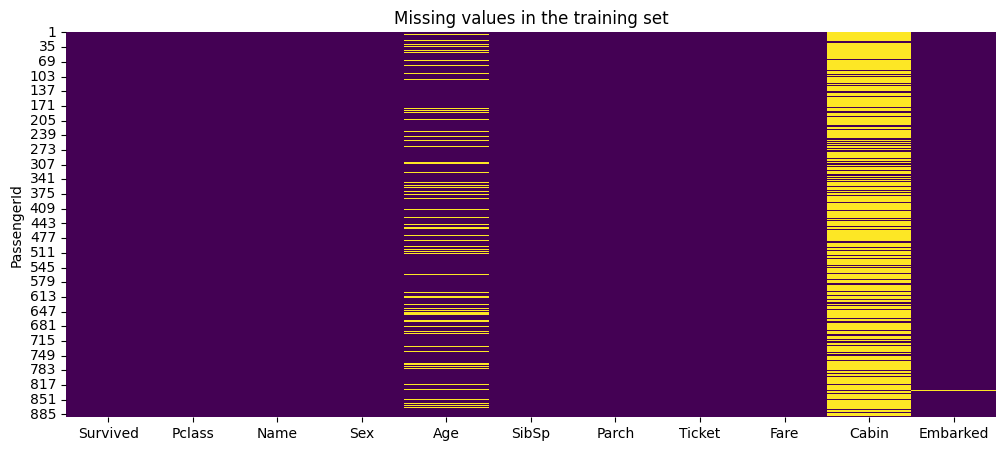

In [73]:
# plotting missing values

plt.figure(figsize=(12, 5))
sns.heatmap(df_train.isnull(), cbar=False, cmap='viridis')
plt.title('Missing values in the training set')
plt.show()


In [74]:
(df_train.isnull().sum()/len(df_train)*100.).sort_values(ascending=False)

Cabin       77.104377
Age         19.865320
Embarked     0.224467
Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
dtype: float64

In [75]:
# seperating numeric and categorical columns

numeric_cols = df_train.select_dtypes(include=[float,int]).columns
categorical_cols = df_train.select_dtypes(include=[object]).columns

print('Numeric columns:', numeric_cols)
print('Categorical columns:', categorical_cols)

Numeric columns: Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')
Categorical columns: Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')


In [76]:
# imputing missing values in the numeric columns

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
df_train[numeric_cols] = imputer.fit_transform(df_train[numeric_cols])

# imputing missing values in the categorical columns

imputer = SimpleImputer(strategy='most_frequent')
df_train[categorical_cols] = imputer.fit_transform(df_train[categorical_cols])

# checking if there are any missing values left

df_train.isnull().sum()


Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64

In [77]:
# encoding the categorical columns

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df_train[categorical_cols] = df_train[categorical_cols].apply(lambda x: encoder.fit_transform(x))

df_train.head()


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3.0,108,1,22.0,1.0,0.0,523,7.2500,47,2
2,1.0,1.0,190,0,38.0,1.0,0.0,596,71.2833,81,0
3,1.0,3.0,353,0,26.0,0.0,0.0,669,7.9250,47,2
4,1.0,1.0,272,0,35.0,1.0,0.0,49,53.1000,55,2
5,0.0,3.0,15,1,35.0,0.0,0.0,472,8.0500,47,2


### Create a Neural network for binary classification

In [84]:
# splitting the data into features and target

X = df_train.drop(['Survived','Name','Ticket'], axis=1)
y = df_train['Survived']

# splitting the data into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaling the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# training the model

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)), # input layer
    tf.keras.layers.Dense(16, activation='relu'),  # hidden layer
    tf.keras.layers.Dense(8, activation='relu'),  # hidden layer
    tf.keras.layers.Dense(1, activation='sigmoid')  # output layer
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test),callbacks=[callback])


print('Training accuracy:', history.history['accuracy'][-1])




c:\Users\AI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6173 - loss: 0.6662 - val_accuracy: 0.7039 - val_loss: 0.6337
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7576 - loss: 0.6129 - val_accuracy: 0.7486 - val_loss: 0.5751
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7418 - loss: 0.5528 - val_accuracy: 0.7598 - val_loss: 0.5192
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7761 - loss: 0.5008 - val_accuracy: 0.7821 - val_loss: 0.4810
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8127 - loss: 0.4589 - val_accuracy: 0.8045 - val_loss: 0.4615
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8340 - loss: 0.4198 - val_accuracy: 0.8101 - val_loss: 0.4565
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8386 - loss: 0.3907 - val_accuracy: 0.7989 - val_loss: 0.4538
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8528 - loss: 0.3739 - val_accuracy: 0.8156 - val_

In [88]:
# removing missing values from test dataset

df_test.info()


<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


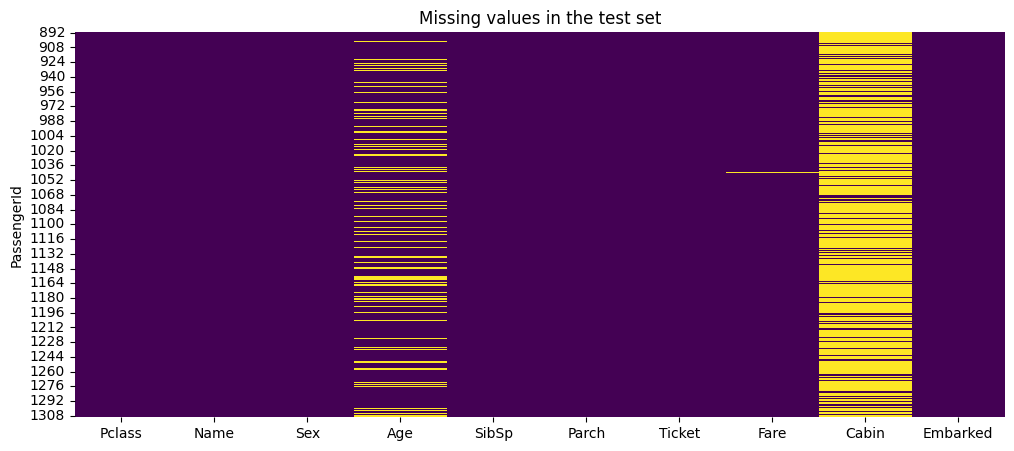

In [89]:
# plotting missing values

plt.figure(figsize=(12, 5))
sns.heatmap(df_test.isnull(), cbar=False, cmap='viridis')
plt.title('Missing values in the test set')
plt.show()


In [92]:
# impute missing values 

numeric_cols1 = df_test.select_dtypes(include=[float,int]).columns
categorical_cols1 = df_test.select_dtypes(include=[object]).columns

print('Numeric columns:', numeric_cols1)
print('Categorical columns:', categorical_cols1)


Numeric columns: Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')
Categorical columns: Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')


In [96]:
# impute missing values in numeric columns

df_test[numeric_cols1] = imputer.fit_transform(df_test[numeric_cols1])

# impute missing values in categorical columns

df_test[categorical_cols1] = imputer.fit_transform(df_test[categorical_cols1])

print('Missing values in the test set:', df_test.isnull().sum())



Missing values in the test set: Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64


In [97]:
# encoding the categorical columns

df_test[categorical_cols1] = df_test[categorical_cols1].apply(lambda x: encoder.fit_transform(x))

df_test.head()


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3.0,206,1,34.5,0.0,0.0,152,7.8292,15,1
893,3.0,403,0,47.0,1.0,0.0,221,7.0000,15,2
894,2.0,269,1,62.0,0.0,0.0,73,9.6875,15,1
895,3.0,408,1,27.0,0.0,0.0,147,8.6625,15,2
896,3.0,178,0,22.0,1.0,1.0,138,12.2875,15,2


In [105]:
# predicting the survived using test dataset and trained model

X1 = df_test.drop(['Name','Ticket'], axis=1)

X1 = scaler.transform(X1)

y_pred = model.predict(X1)

y_pred = (y_pred > 0.5).astype(int)

y_pred = y_pred.reshape(-1)

y_pred[:10]

# creating submission file

submission = pd.DataFrame({'PassengerId': df_test.index, 'Survived': y_pred})



submission.to_csv('submission.csv', index=False)

submission.head()






14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
